In [ ]:
!pip install tensorflow-addons
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 20.5 MB/s eta 0:00:00


In [ ]:
import random
import math
import time
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Multiply, Reshape
from tensorflow.keras.layers import Add, Activation, ZeroPadding2D, BatchNormalization, AveragePooling2D, Input, ReLU, Concatenate

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Preprocessing**

In [ ]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

In [ ]:
def make_path_label_df(imgpath):
    dir = Path(imgpath)
    filepaths = []
    labels = []

    print(f"Subdirectories: {[x.name for x in dir.iterdir() if x.is_dir()]}")

    for class_folder in dir.iterdir():
        if class_folder.is_dir():

            print(f"Processing: {class_folder.name}")

            for img in class_folder.glob('*.*'):
                filepaths.append(str(img))
                labels.append(class_folder.name)

    filepaths = pd.Series(filepaths, name='filepath').astype(str)
    labels = pd.Series(labels, name='label')

    df = pd.concat([filepaths, labels], axis=1)
    return df

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/HDA PRO/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'
df = make_path_label_df(path)

Subdirectories: ['pneumonia', 'normal', 'covid']
Processing: pneumonia
Processing: normal
Processing: covid


In [ ]:
print(df['label'].value_counts())

label
pneumonia    1525
normal       1525
covid        1525
Name: count, dtype: int64


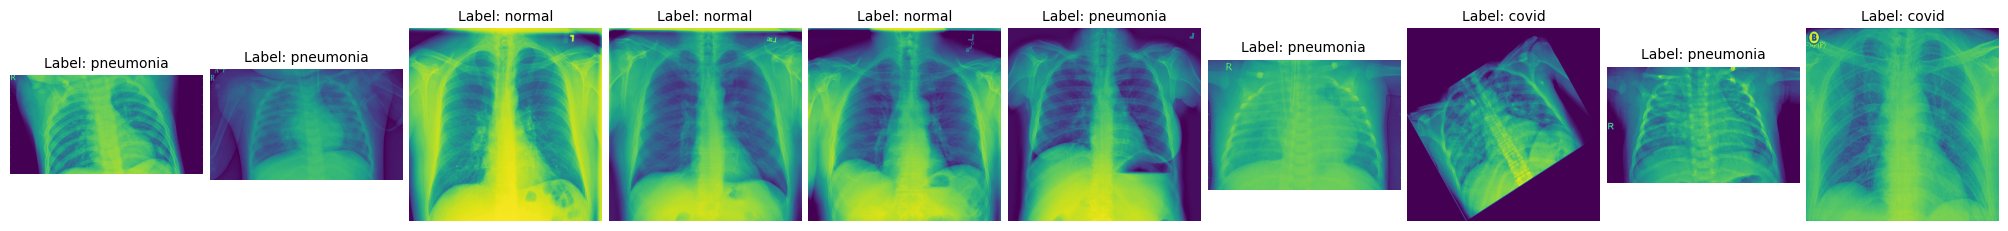

In [ ]:
def show_random_images(dataframe, num_images=10, seed=42):

    random.seed(seed)

    # Increase the figure's width to give more space to each subplot
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    random_indices = random.sample(range(len(dataframe)), min(len(dataframe), num_images))

    for i, ax in enumerate(axes):
        # Get a random index
        idx = random_indices[i]
        img = Image.open(dataframe.iloc[idx]['filepath'])
        ax.imshow(img)  # Display image in its original format
        ax.set_title(f"Label: {dataframe.iloc[idx]['label']}", fontsize=10)
        ax.axis('off')

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)  # Adjust padding
    plt.show()

show_random_images(df, num_images=10)

As it can be seen, there are some issues with the input images. they are not all the same size and some of them have different width to height ratios. Some of them are flipped or rotated and they are not all gray scale.

To deal with these issues we decided to use two functions and prepare 2 types of datasets. Both of these functions change the data to grayscale and normalize them. The difference is that in the first function, the images are resized (stretched) to have a square shape of a target size of 224x224 pxl. In the second function, we initially aimed to introduce a function which crop the image (if the target image size is smaller) or pad (if the target image size is bigger) but since most of the original images have high dimension, they were cropped to very small images which were not appropriate. Therefore, in the second function all the images are just padded to a constant square dimensions.

In [ ]:
def resize_image(image, label):
    """
    Check the image's number of channels and convert to grayscale if it's RGB.
    Resize the image to the target size and normalize pixel values.

    Args:
    image (tf.Tensor): The image tensor.
    label: The label corresponding to the image.

    Returns:
    tf.Tensor: The processed image tensor.
    label: The label corresponding to the image.
    """

    image = tf.image.convert_image_dtype(image, tf.float32)  # Ensure correct type and normalize
    if image.shape[-1] == 3:
        image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale only if RGB
    image = tf.image.resize(image, [224, 224])  # Resize the image
    image = tf.expand_dims(image, -1)  # Ensure it has a consistent shape

    return image, label

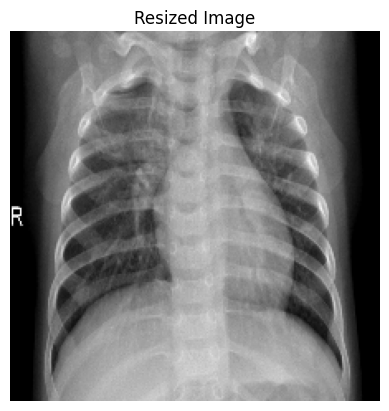

In [ ]:
# Load the image file
image_example_path = df['filepath'].iloc[0]
image_example = tf.io.read_file(image_example_path)
image_example = tf.image.decode_jpeg(image_example, channels=3)  # Decode with 3 channels

# Apply the resize and grayscale conversion function (using a dummy label, e.g. 0)
resized_image_example, _ = resize_image(image_example, 0)

# The image might still have a channel dimension (1) after resizing and grayscaling, so we squeeze it
resized_image_example = tf.squeeze(resized_image_example)

# Display the image
plt.imshow(resized_image_example, cmap='gray')
plt.title('Resized Image')
plt.axis('off')
plt.show()


In [ ]:
def pad_image(image, label):
    """
    Check the image's number of channels and convert to grayscale if it's RGB.
    Pad the image to the target size and normalize pixel values.

    Args:
    image (tf.Tensor): The image tensor.
    label: The label corresponding to the image.

    Returns:
    tf.Tensor: The processed image tensor.
    label: The label corresponding to the image.
    """
    image = tf.image.convert_image_dtype(image, tf.float32)  # Ensure correct type and normalize
    if image.shape[-1] == 3:
        image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale only if RGB
    image = tf.image.resize_with_pad(image, 224, 224)  # Pad the image to the target size
    image = tf.expand_dims(image, -1)  # Ensure it has a consistent shape, if needed

    return image, label


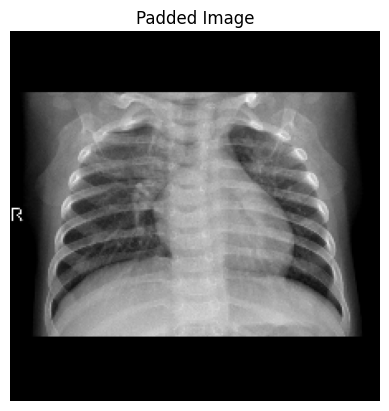

In [ ]:
# Load the image file
image_path_example = df['filepath'].iloc[0]
image_example = tf.io.read_file(image_path_example)
image_example = tf.image.decode_jpeg(image_example, channels=3)  # Decode with 3 channels

# Apply the pad function (using a dummy label, e.g., 0)
padded_image_example, _ = pad_image(image_example, 0)

# Squeeze the image to remove the channel dimension for display
padded_image_example = tf.squeeze(padded_image_example)

# Display the image
plt.imshow(padded_image_example, cmap='gray')  # Specify the colormap to 'gray'
plt.title('Padded Image')
plt.axis('off')
plt.show()


In [ ]:
df['label'] = df['label'].astype('category').cat.codes

Now we create train, validation and test datasets:

In [ ]:
def load_and_preprocess_image(file_path, label, preprocess_func, augment=False):
    # Ensure file_path is a string tensor
    file_path = tf.ensure_shape(file_path, [])
    # Read the image file
    image = tf.io.read_file(file_path)
    # Decode the image
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image.set_shape([None, None, 3])

    # Apply augmentation if flag is True
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        # Add more augmentations as needed
        # Example: Random brightness adjustment
        image = tf.image.random_brightness(image, max_delta=0.1)

        # Random rotation
        max_degrees = 20
        degrees = tf.random.uniform([], -max_degrees, max_degrees, dtype=tf.float32)
        radians = degrees * math.pi / 180
        image = tfa.image.rotate(image, radians)

    # Apply the provided preprocessing function (e.g., resize or pad)
    image, label = preprocess_func(image, label)
    return image, label


In [ ]:
def create_train_val_test_datasets(df, preprocess_func, batch_size=32, seed=42):
    # Split the dataframe into (training + validation) and test sets
    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['label'])
    train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=seed, stratify=train_val_df['label'])

    # Creating the training dataset with augmentation
    train_dataset = tf.data.Dataset.from_tensor_slices((train_df['filepath'].values, train_df['label'].values))
    train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, preprocess_func, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(buffer_size=len(train_df)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Creating the validation dataset without augmentation
    val_dataset = tf.data.Dataset.from_tensor_slices((val_df['filepath'].values, val_df['label'].values))
    val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y, preprocess_func, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Test dataset creation remains the same as validation
    test_dataset = tf.data.Dataset.from_tensor_slices((test_df['filepath'].values, test_df['label'].values))
    test_dataset = test_dataset.map(lambda x, y: load_and_preprocess_image(x, y, preprocess_func, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset

In [ ]:
# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Whether to restore model weights from the epoch with the best value of the monitored quantity
    verbose=1            # Whether to output a message when training is stopped
)

Calculating confusion matrix:

In [ ]:
def plot_confusion_matrix(dataset, model, class_names, title='Confusion Matrix'):
    y_preds = []
    y_true = []

    for images, labels in dataset:
        # Generate predictions
        preds = model.predict(images)
        preds = np.argmax(preds, axis=-1)
        y_preds.extend(preds)

        # Extract true labels
        if labels.ndim > 1:  # Check for one-hot encoded labels
            labels = np.argmax(labels, axis=-1)
        y_true.extend(labels)

    # Ensure labels and predictions are numpy arrays
    y_true = np.array(y_true)
    y_preds = np.array(y_preds)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_preds)

    # Plotting
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
    plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
    plt.show()

# First CNN model:

In [ ]:
def create_custom_cnn(input_shape, num_classes=3):  # Setting num_classes to 3 for our dataset
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax'),  # Output layer for 3 classes
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Example of creating a model for 3 classes
model = create_custom_cnn((224, 224, 1), 3)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

**Using resized dataset to train the model:**

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, resize_image, batch_size=32, seed=42)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/Custom_CNN_resized',  # Path and file name to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,               # Log a message for each save
    save_best_only=True,     # Only save a model if `val_accuracy` has improved
    mode='max',              # `max` because we aim to maximize the validation accuracy
    save_weights_only=False  # Save the entire model
)

In [ ]:
# Start timing
start_time = time.time()

# Train the model
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping_callback, checkpoint_callback]  # Add the callback to the callbacks list
)

# Calculate the total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")


Epoch 1/15
86/86 [==============================] - ETA: 0s - loss: 0.8636 - accuracy: 0.6084
Epoch 1: val_accuracy improved from -inf to 0.77596, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/Custom_CNN_resized
86/86 [==============================] - 258s 475ms/step - loss: 0.8636 - accuracy: 0.6084 - val_loss: 0.6230 - val_accuracy: 0.7760
Epoch 2/15
85/86 [============================>.] - ETA: 0s - loss: 0.5826 - accuracy: 0.7680
Epoch 2: val_accuracy improved from 0.77596 to 0.80328, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/Custom_CNN_resized
86/86 [==============================] - 62s 83ms/step - loss: 0.5825 - accuracy: 0.7679 - val_loss: 0.5572 - val_accuracy: 0.8033
Epoch 3/15
85/86 [============================>.] - ETA: 0s - loss: 0.4890 - accuracy: 0.8202
Epoch 3: val_accuracy improved from 0.80328 to 0.83934, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/Custom_CNN_resized
86/86 [============

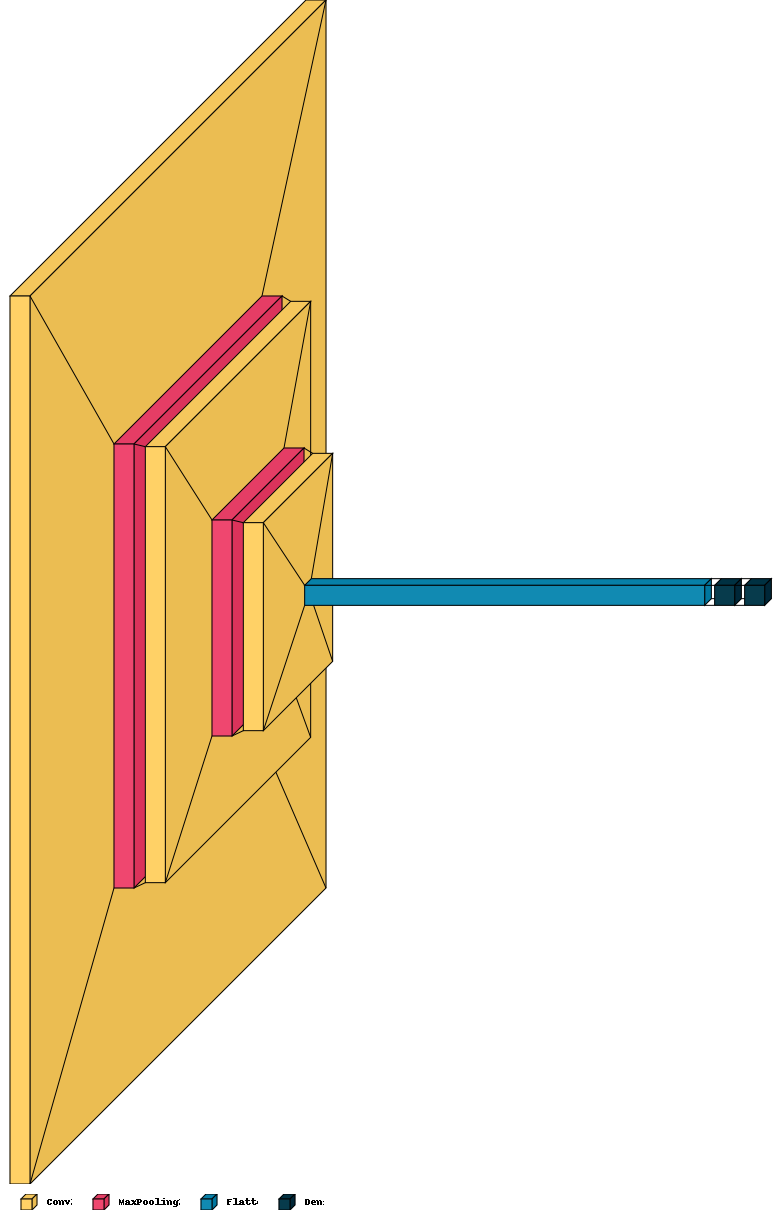

In [ ]:
visualkeras.layered_view(model, legend=True) #visually display the model

In [ ]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

86/86 [==============================] - 55s 11ms/step - loss: 0.1864 - accuracy: 0.9384
Training Loss: 0.1863730549812317
Training Accuracy: 0.9384335279464722
29/29 [==============================] - 4s 112ms/step - loss: 0.3400 - accuracy: 0.8940
Validation Loss: 0.34003880620002747
Validation Accuracy: 0.893989086151123


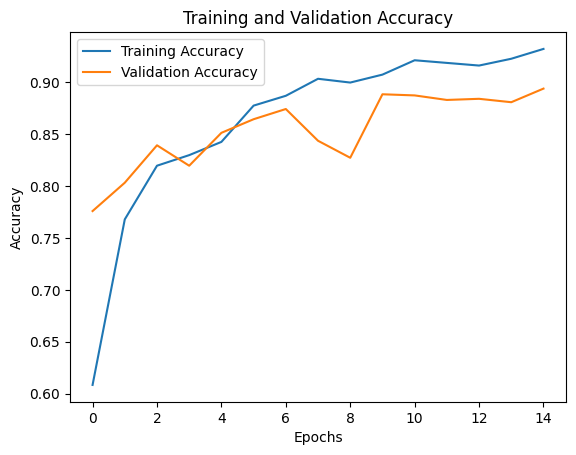

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

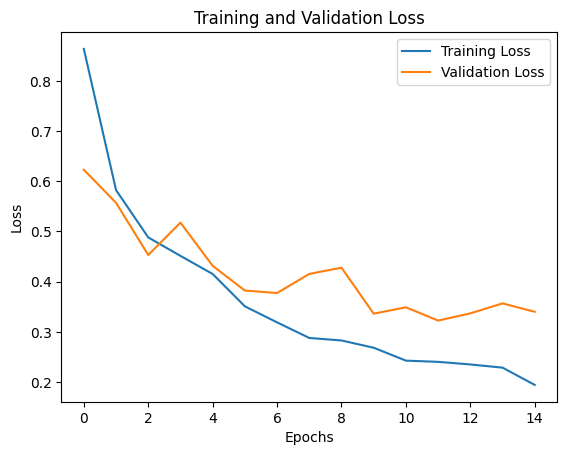

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 84ms/step


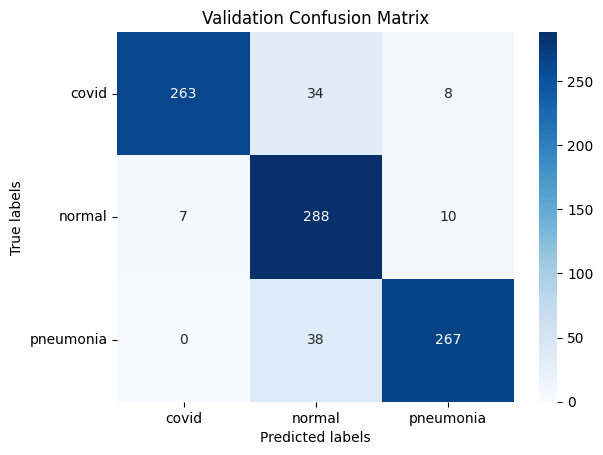

In [ ]:
class_names = ['covid', 'normal', 'pneumonia']
plot_confusion_matrix(val_dataset, model, class_names, title='Validation Confusion Matrix')

**Using padded dataset to train the model:**

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, pad_image, batch_size=32, seed=42)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/Custom_CNN_padded',  # Path and file name to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,               # Log a message for each save
    save_best_only=True,     # Only save a model if `val_accuracy` has improved
    mode='max',              # `max` because we aim to maximize the validation accuracy
    save_weights_only=False  # Save the entire model
)

In [ ]:
# Start timing
start_time = time.time()

# Train the model
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping_callback, checkpoint_callback]  # Add the callback to the callbacks list
)

# Calculate the total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/15
85/86 [============================>.] - ETA: 0s - loss: 0.2505 - accuracy: 0.9081
Epoch 1: val_accuracy improved from -inf to 0.89290, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/Custom_CNN_padded
86/86 [==============================] - 61s 84ms/step - loss: 0.2501 - accuracy: 0.9082 - val_loss: 0.3204 - val_accuracy: 0.8929
Epoch 2/15
85/86 [============================>.] - ETA: 0s - loss: 0.1984 - accuracy: 0.9360
Epoch 2: val_accuracy improved from 0.89290 to 0.89836, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/Custom_CNN_padded
86/86 [==============================] - 62s 83ms/step - loss: 0.1980 - accuracy: 0.9362 - val_loss: 0.3006 - val_accuracy: 0.8984
Epoch 3/15
85/86 [============================>.] - ETA: 0s - loss: 0.1780 - accuracy: 0.9393
Epoch 3: val_accuracy did not improve from 0.89836
86/86 [==============================] - 61s 71ms/step - loss: 0.1779 - accuracy: 0.9392 - val_loss: 0.3295 - val_accu

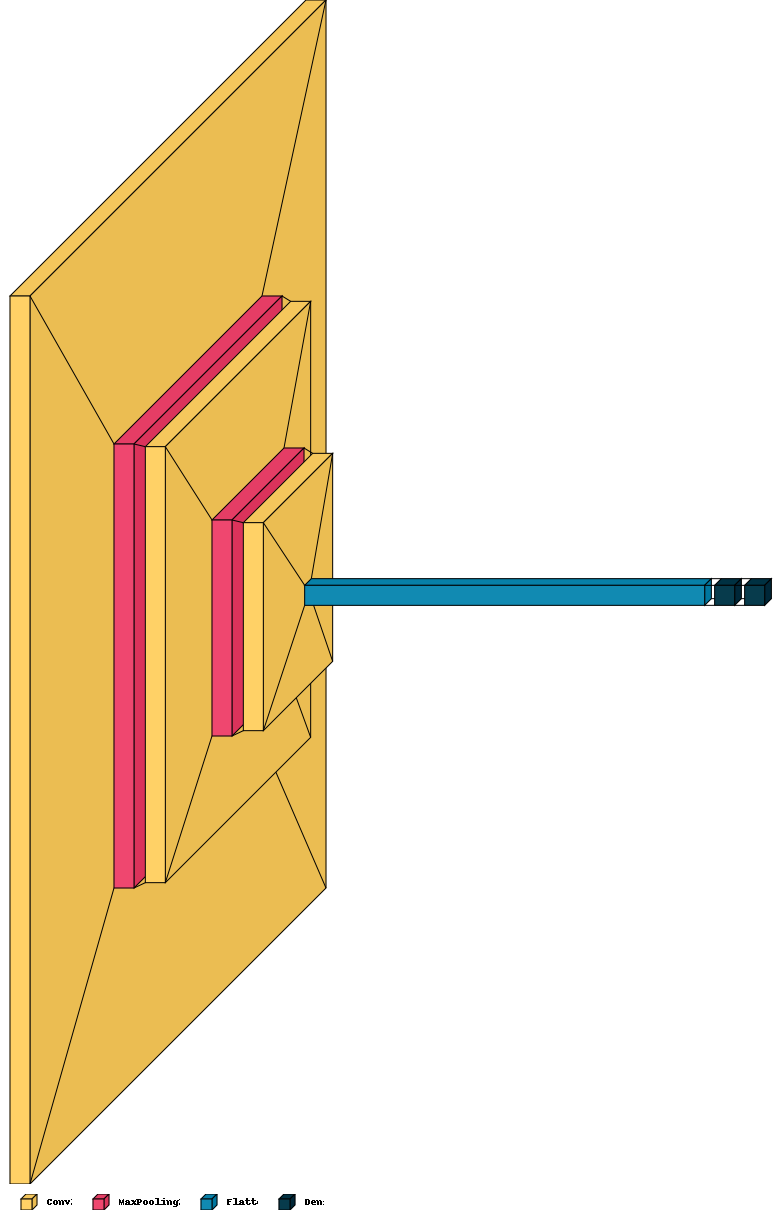

In [ ]:
visualkeras.layered_view(model, legend=True) #visually display the model

In [ ]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

86/86 [==============================] - 55s 12ms/step - loss: 0.1664 - accuracy: 0.9439
Training Loss: 0.16638675332069397
Training Accuracy: 0.9438980221748352
29/29 [==============================] - 4s 111ms/step - loss: 0.3006 - accuracy: 0.8984
Validation Loss: 0.30062413215637207
Validation Accuracy: 0.8983606696128845


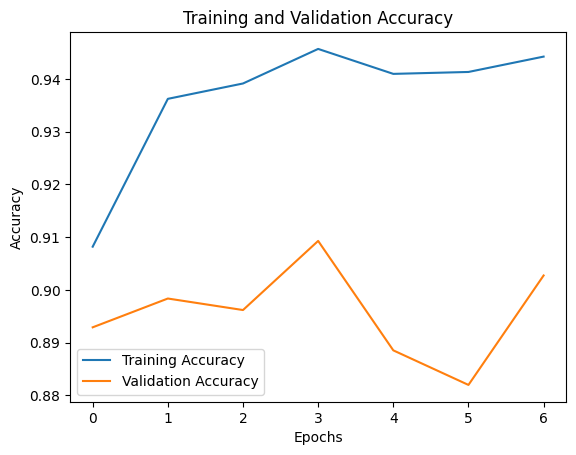

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

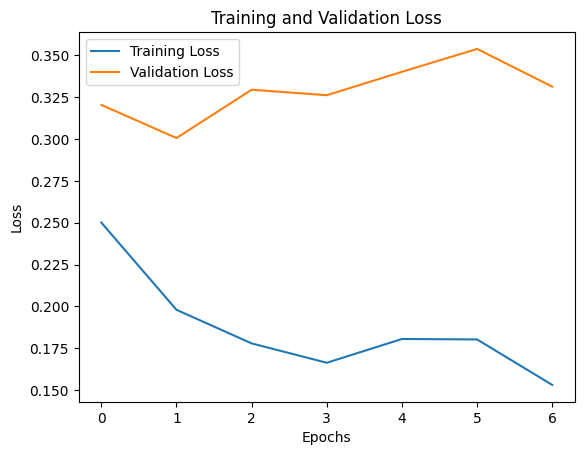

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 22ms/step


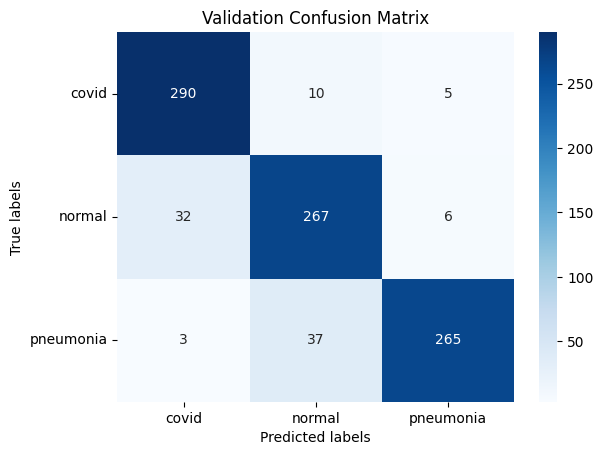

In [ ]:
class_names = ['covid', 'normal', 'pneumonia']
plot_confusion_matrix(val_dataset, model, class_names, title='Validation Confusion Matrix')

# Second CNN model with attention mechanism

In [ ]:
def create_advanced_cnn_with_attention(input_shape, num_classes=3):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),  # Adding back the convolutional layers
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),  # Ensuring the same number of Conv layers
        MaxPooling2D((2, 2)),
    ])

    # Squeeze and Excitation block
    se = GlobalAveragePooling2D()(model.output)
    se = Dense(64, activation='relu')(se)
    se = Dense(128, activation='sigmoid')(se)
    se = Reshape([1, 1, 128])(se)  # Reshape to match the feature map dimensions
    se = Multiply()([model.output, se])

    # Continuing the model
    x = Flatten()(se)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    final_model = Model(inputs=model.input, outputs=x)

    final_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

    return final_model

# Create the model with the specified input shape and number of classes
model = create_advanced_cnn_with_attention((224, 224, 1), 3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_3_input (InputLayer  [(None, 224, 224, 1)]        0         []                            
 )                                                                                                
                                                                                                  
 conv2d_3 (Conv2D)           (None, 222, 222, 32)         320       ['conv2d_3_input[0][0]']      
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                              

**Using resized dataset to train the model:**

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, resize_image, batch_size=32, seed=42)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/Second_Custom_CNN_resized',  # Path and file name to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,               # Log a message for each save
    save_best_only=True,     # Only save a model if `val_accuracy` has improved
    mode='max',              # `max` because we aim to maximize the validation accuracy
    save_weights_only=False  # Save the entire model
)

In [ ]:
# Start timing
start_time = time.time()

# Train the model
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping_callback, checkpoint_callback]  # Add the callback to the callbacks list
)

# Calculate the total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/15
86/86 [==============================] - ETA: 0s - loss: 0.8759 - accuracy: 0.5872
Epoch 1: val_accuracy improved from -inf to 0.68634, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/Second_Custom_CNN_resized
86/86 [==============================] - 67s 101ms/step - loss: 0.8759 - accuracy: 0.5872 - val_loss: 0.7274 - val_accuracy: 0.6863
Epoch 2/15
85/86 [============================>.] - ETA: 0s - loss: 0.6288 - accuracy: 0.7441
Epoch 2: val_accuracy improved from 0.68634 to 0.74426, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/Second_Custom_CNN_resized
86/86 [==============================] - 62s 87ms/step - loss: 0.6315 - accuracy: 0.7432 - val_loss: 0.5913 - val_accuracy: 0.7443
Epoch 3/15
85/86 [============================>.] - ETA: 0s - loss: 0.5470 - accuracy: 0.7923
Epoch 3: val_accuracy improved from 0.74426 to 0.81858, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/Second_Custom_CNN_resized

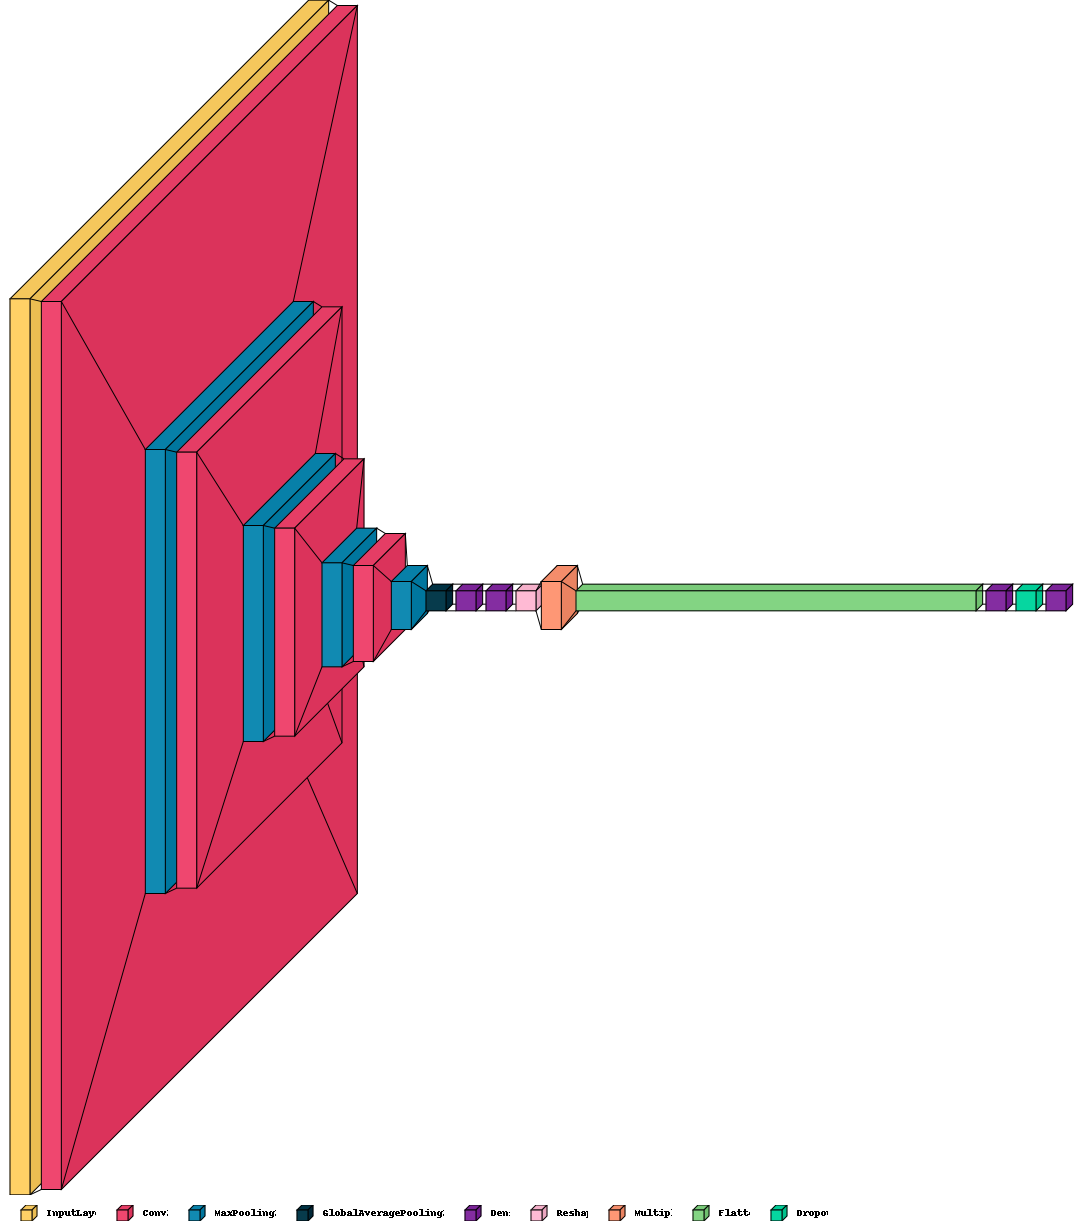

In [ ]:
visualkeras.layered_view(model, legend=True) #visually display the model

In [ ]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

86/86 [==============================] - 55s 13ms/step - loss: 0.1889 - accuracy: 0.9395
Training Loss: 0.18890663981437683
Training Accuracy: 0.9395264387130737
29/29 [==============================] - 3s 110ms/step - loss: 0.2894 - accuracy: 0.9016
Validation Loss: 0.2893947660923004
Validation Accuracy: 0.9016393423080444


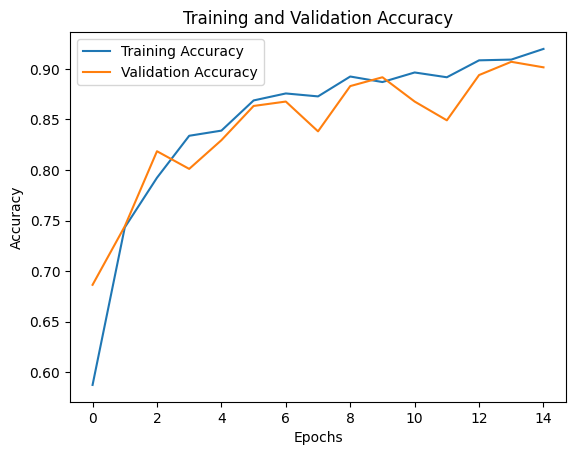

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

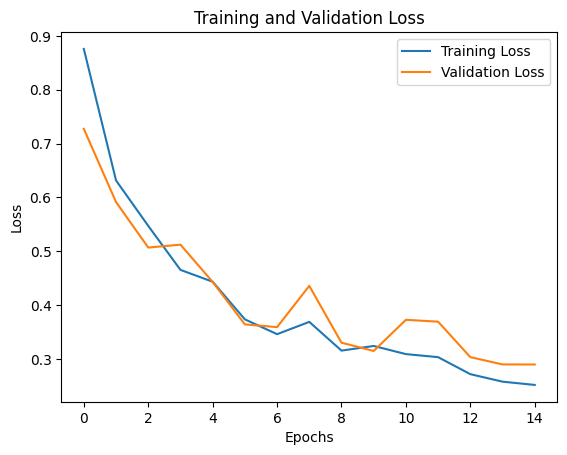

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 115ms/step


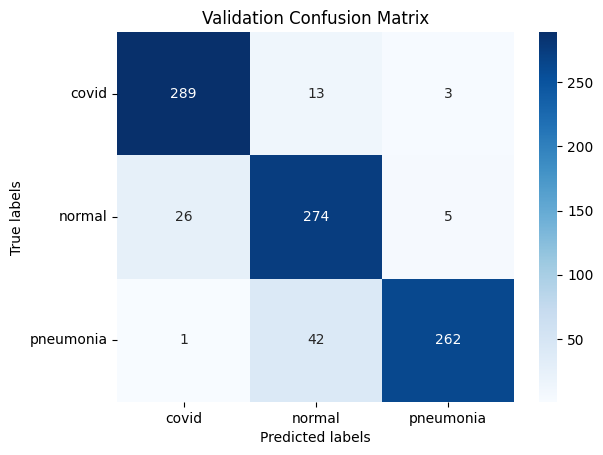

In [ ]:
class_names = ['covid', 'normal', 'pneumonia']
plot_confusion_matrix(val_dataset, model, class_names, title='Validation Confusion Matrix')

**Using padded dataset to train the model:**

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, pad_image, batch_size=32, seed=42)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/Second_Custom_CNN_padded',  # Path and file name to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,               # Log a message for each save
    save_best_only=True,     # Only save a model if `val_accuracy` has improved
    mode='max',              # `max` because we aim to maximize the validation accuracy
    save_weights_only=False  # Save the entire model
)

In [ ]:
# Start timing
start_time = time.time()

# Train the model
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping_callback, checkpoint_callback]  # Add the callback to the callbacks list
)

# Calculate the total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/15
85/86 [============================>.] - ETA: 0s - loss: 0.3123 - accuracy: 0.9007
Epoch 1: val_accuracy improved from -inf to 0.88634, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/Second_Custom_CNN_padded
86/86 [==============================] - 62s 89ms/step - loss: 0.3128 - accuracy: 0.9009 - val_loss: 0.3781 - val_accuracy: 0.8863
Epoch 2/15
85/86 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.9217
Epoch 2: val_accuracy did not improve from 0.88634
86/86 [==============================] - 60s 72ms/step - loss: 0.2510 - accuracy: 0.9213 - val_loss: 0.3196 - val_accuracy: 0.8831
Epoch 3/15
85/86 [============================>.] - ETA: 0s - loss: 0.2369 - accuracy: 0.9246
Epoch 3: val_accuracy improved from 0.88634 to 0.90929, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/Second_Custom_CNN_padded
86/86 [==============================] - 62s 93ms/step - loss: 0.2373 - accuracy: 0.9246 - val_loss: 0.2

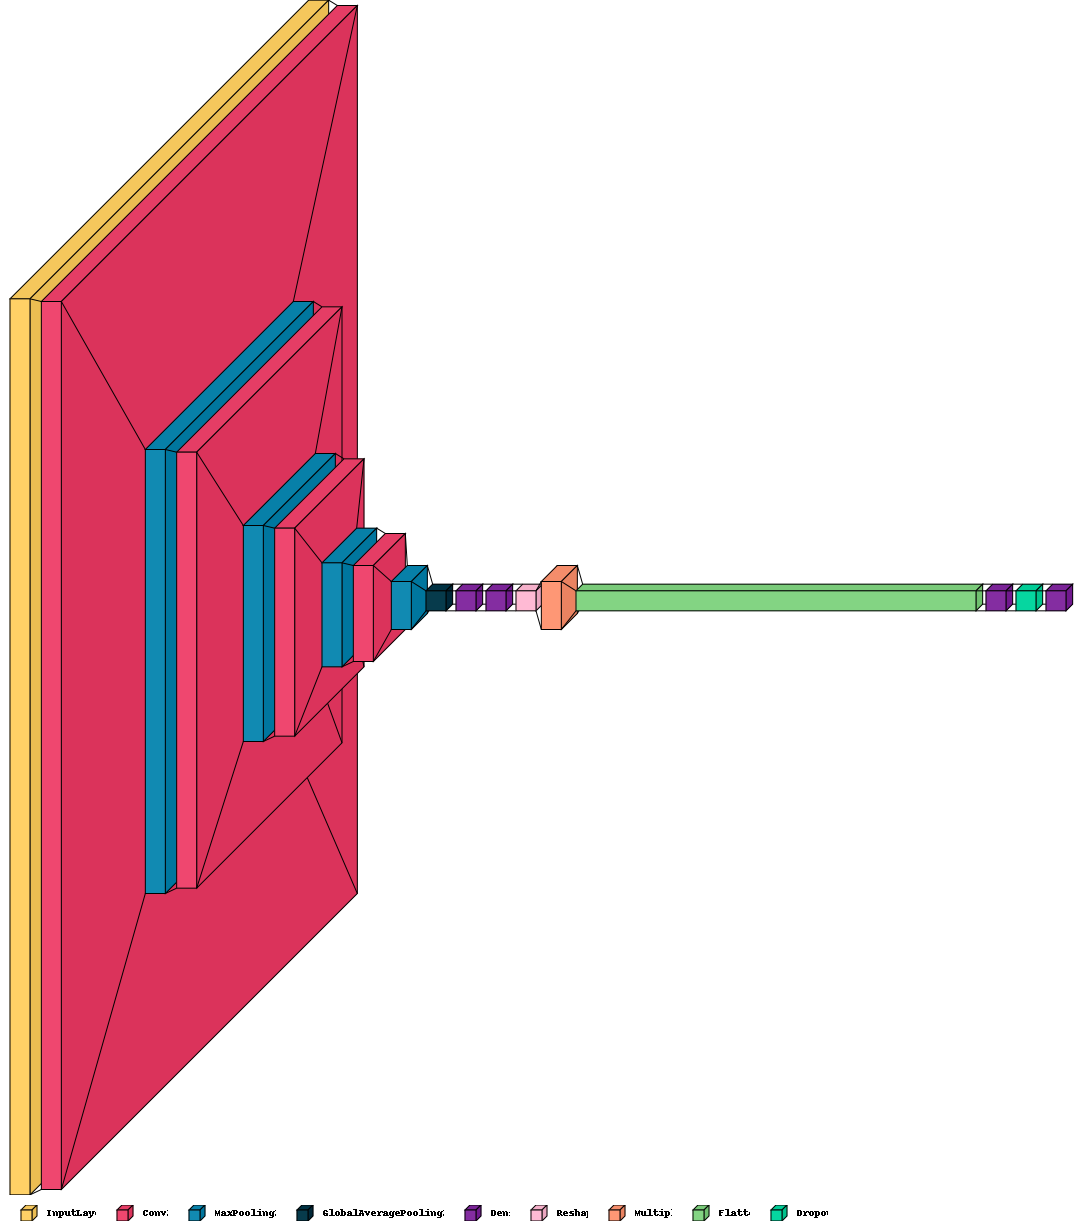

In [ ]:
visualkeras.layered_view(model, legend=True) #visually display the model

In [ ]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

86/86 [==============================] - 55s 13ms/step - loss: 0.1176 - accuracy: 0.9617
Training Loss: 0.11763308197259903
Training Accuracy: 0.9617486596107483
29/29 [==============================] - 4s 112ms/step - loss: 0.2496 - accuracy: 0.9180
Validation Loss: 0.24963998794555664
Validation Accuracy: 0.9180327653884888


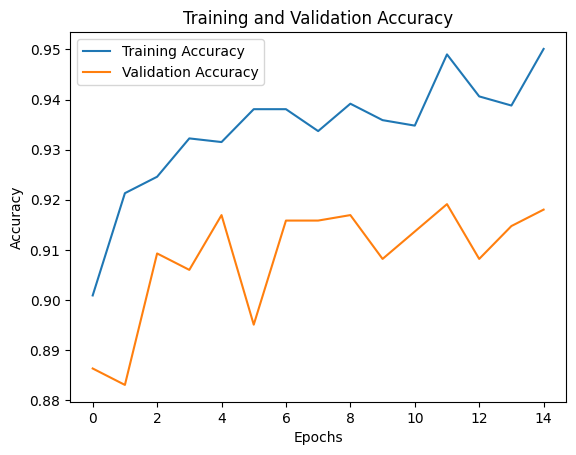

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

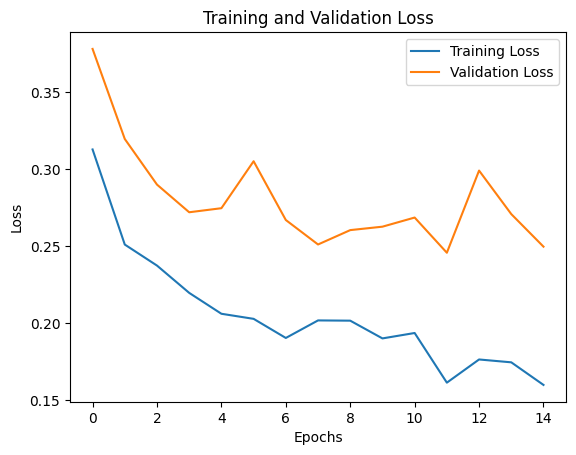

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 23ms/step


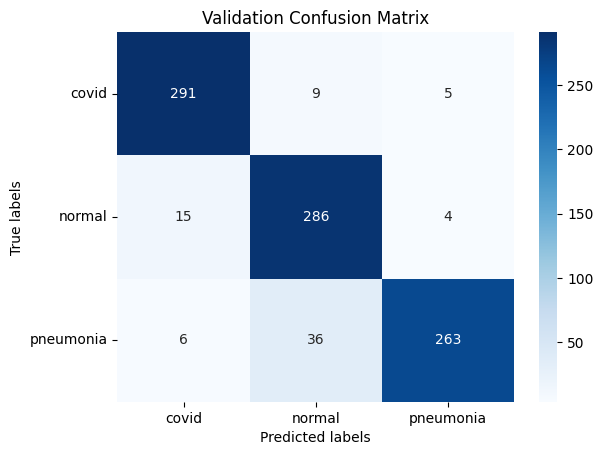

In [ ]:
class_names = ['covid', 'normal', 'pneumonia']
plot_confusion_matrix(val_dataset, model, class_names, title='Validation Confusion Matrix')

# ResNet-34 Architecture

In [ ]:
def basic_block(input_tensor, kernel_size, filters, stage, block, strides=(1, 1)):
    """A basic residual block for ResNet-34."""
    filters1, filters2 = filters
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # First component of the main path
    x = Conv2D(filters1, kernel_size, strides=strides, padding='same', name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    # Second component of the main path
    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)

    # Shortcut path
    if strides != (1, 1):
        shortcut = Conv2D(filters2, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
        shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)
    else:
        shortcut = input_tensor

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet34(input_shape=(224, 224, 1), classes=3):
    img_input = Input(shape=input_shape)
    x = ZeroPadding2D(padding=(3, 3))(img_input)

    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Stage 2
    x = basic_block(x, 3, [64, 64], stage=2, block='a')
    x = basic_block(x, 3, [64, 64], stage=2, block='b')
    x = basic_block(x, 3, [64, 64], stage=2, block='c')

    # Stage 3
    x = basic_block(x, 3, [128, 128], stage=3, block='a', strides=(2, 2))
    x = basic_block(x, 3, [128, 128], stage=3, block='b')
    x = basic_block(x, 3, [128, 128], stage=3, block='c')
    x = basic_block(x, 3, [128, 128], stage=3, block='d')

    # Stage 4
    x = basic_block(x, 3, [256, 256], stage=4, block='a', strides=(2, 2))
    x = basic_block(x, 3, [256, 256], stage=4, block='b')
    x = basic_block(x, 3, [256, 256], stage=4, block='c')
    x = basic_block(x, 3, [256, 256], stage=4, block='d')
    x = basic_block(x, 3, [256, 256], stage=4, block='e')
    x = basic_block(x, 3, [256, 256], stage=4, block='f')

    # Stage 5
    x = basic_block(x, 3, [512, 512], stage=5, block='a', strides=(2, 2))
    x = basic_block(x, 3, [512, 512], stage=5, block='b')
    x = basic_block(x, 3, [512, 512], stage=5, block='c')

    # Final layers and global average pooling
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax', name='fc' + str(classes))(x)


    # Create model
    model = Model(img_input, x, name='resnet34')

    # Compile the model with a specific learning rate
    optimizer = Adam(learning_rate=1e-5)  # Setting the learning rate
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate and compile the ResNet34 model
model = ResNet34(input_shape=(224, 224, 1), classes=3)
model.summary()


Model: "resnet34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, 230, 230, 1)          0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 64)         3200      ['zero_padding2d_6[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1[0][0]']        

**Using resized dataset to train the model:**

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, resize_image, batch_size=32, seed=42)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-34_resized',  # Path and file name to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,               # Log a message for each save
    save_best_only=True,     # Only save a model if `val_accuracy` has improved
    mode='max',              # `max` because we aim to maximize the validation accuracy
    save_weights_only=False  # Save the entire model
)

In [ ]:
# Start timing
start_time = time.time()

early_stopping_callback.patience = 10 #Setting patience value to 10

# Train the model
epochs = 40
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping_callback, checkpoint_callback]  # Add the callback to the callbacks list
)

# Calculate the total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/40
86/86 [==============================] - ETA: 0s - loss: 0.9899 - accuracy: 0.5621
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-34_resized
86/86 [==============================] - 101s 302ms/step - loss: 0.9899 - accuracy: 0.5621 - val_loss: 1.3408 - val_accuracy: 0.3333
Epoch 2/40
86/86 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.7381
Epoch 2: val_accuracy did not improve from 0.33333
86/86 [==============================] - 65s 116ms/step - loss: 0.6663 - accuracy: 0.7381 - val_loss: 1.9979 - val_accuracy: 0.3333
Epoch 3/40
86/86 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.8051
Epoch 3: val_accuracy did not improve from 0.33333
86/86 [==============================] - 65s 116ms/step - loss: 0.5366 - accuracy: 0.8051 - val_loss: 2.2720 - val_accuracy: 0.3169
Epoch 4/40
86/86 [==============================] - ETA: 0s - loss: 0.4701 - 

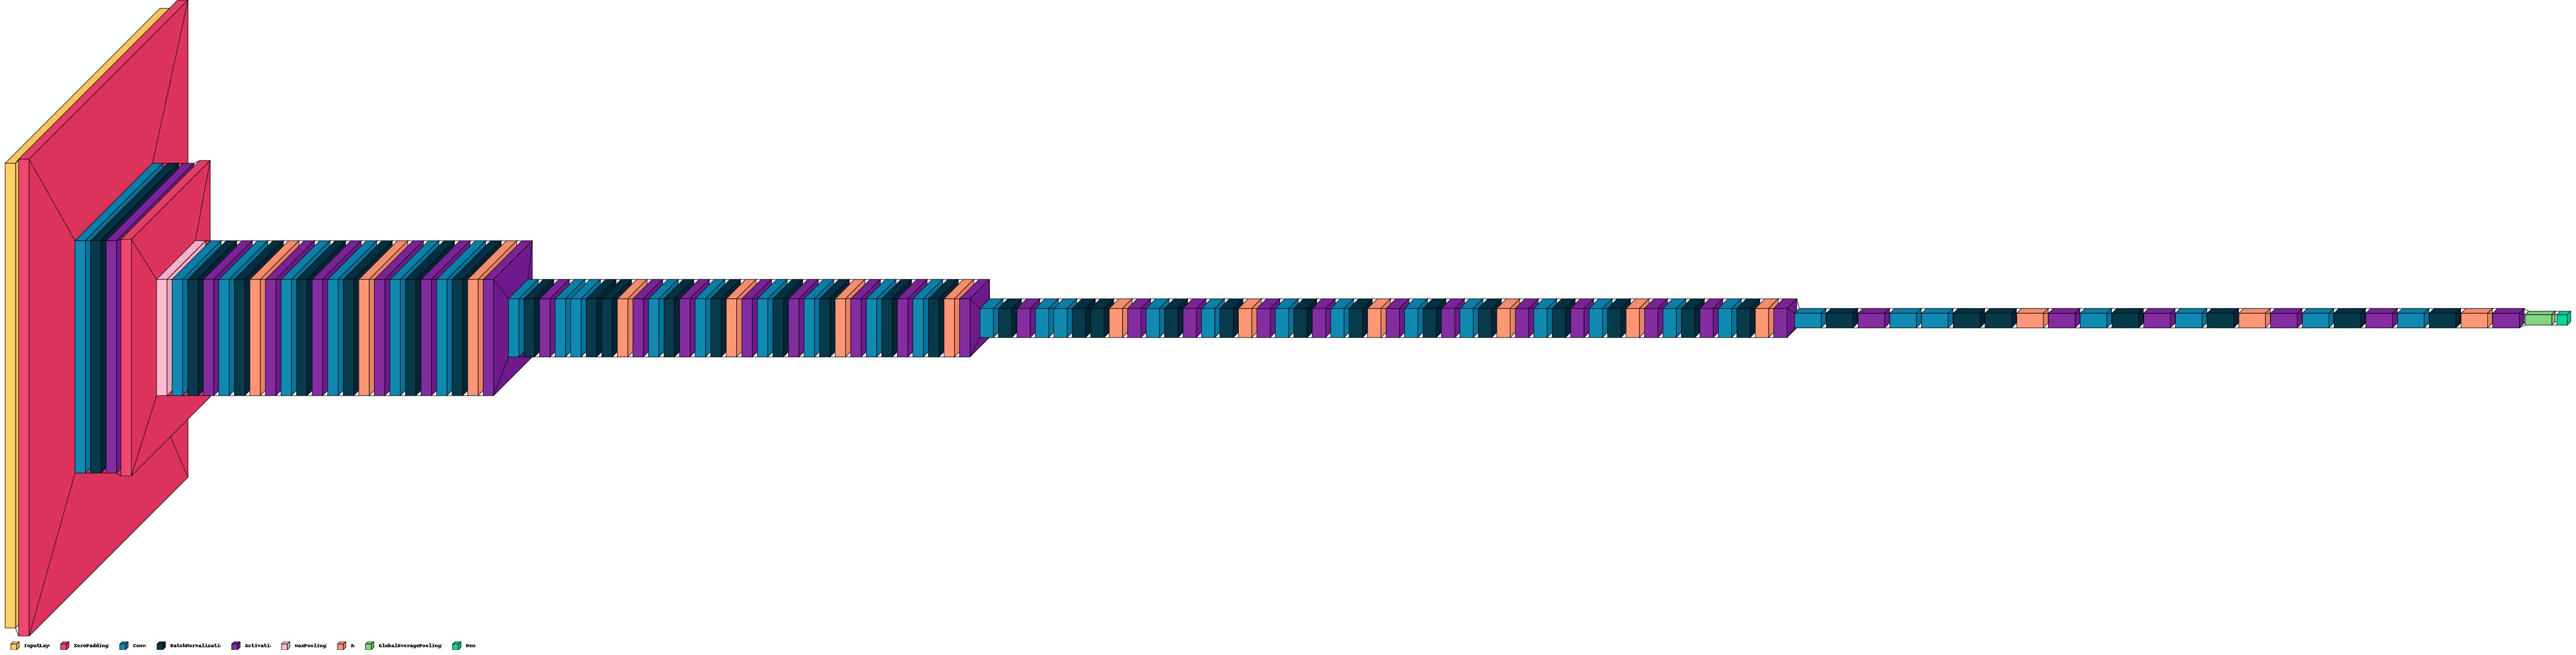

In [ ]:
visualkeras.layered_view(model, legend=True) #visually display the model

In [ ]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

86/86 [==============================] - 56s 22ms/step - loss: 0.2105 - accuracy: 0.9304
Training Loss: 0.21049819886684418
Training Accuracy: 0.9304189682006836
29/29 [==============================] - 3s 103ms/step - loss: 0.3621 - accuracy: 0.8754
Validation Loss: 0.362055242061615
Validation Accuracy: 0.8754098415374756


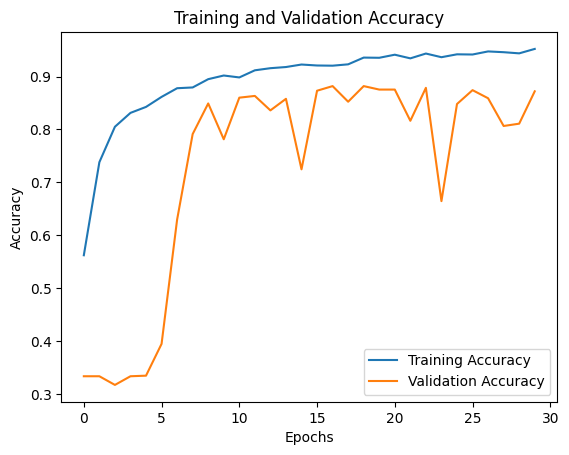

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

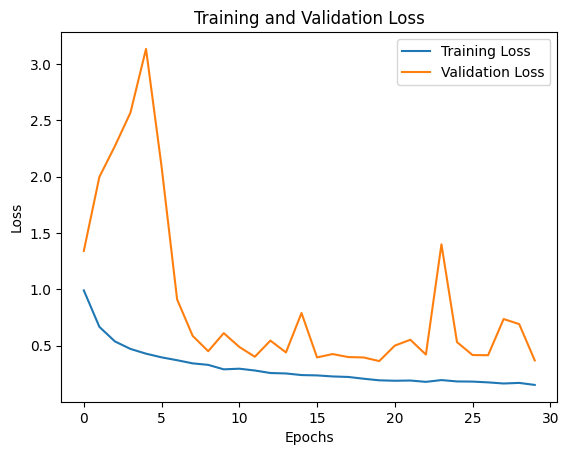

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 1s 676ms/step


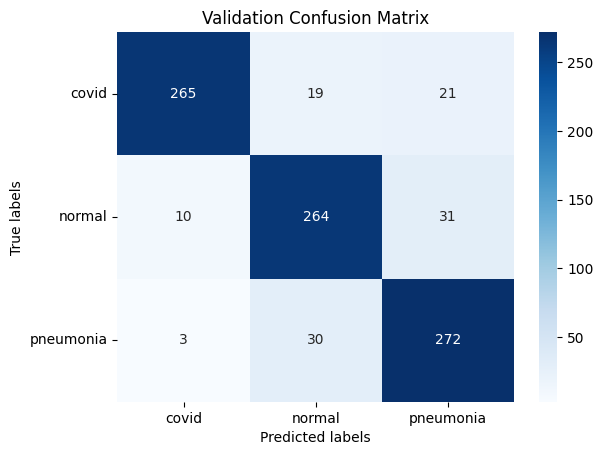

In [ ]:
class_names = ['covid', 'normal', 'pneumonia']
plot_confusion_matrix(val_dataset, model, class_names, title='Validation Confusion Matrix')

**Using padded dataset to train the model:**

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, pad_image, batch_size=32, seed=42)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-34_padded',  # Path and file name to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,               # Log a message for each save
    save_best_only=True,     # Only save a model if `val_accuracy` has improved
    mode='max',              # `max` because we aim to maximize the validation accuracy
    save_weights_only=False  # Save the entire model
)

In [ ]:
# Start timing
start_time = time.time()

# Train the model
epochs = 40
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping_callback, checkpoint_callback]  # Add the callback to the callbacks list
)

# Calculate the total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/40
86/86 [==============================] - ETA: 0s - loss: 0.3956 - accuracy: 0.8623
Epoch 1: val_accuracy improved from -inf to 0.70273, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-34_padded
86/86 [==============================] - 80s 297ms/step - loss: 0.3956 - accuracy: 0.8623 - val_loss: 0.9509 - val_accuracy: 0.7027
Epoch 2/40
86/86 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.9024
Epoch 2: val_accuracy improved from 0.70273 to 0.84262, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-34_padded
86/86 [==============================] - 80s 290ms/step - loss: 0.2861 - accuracy: 0.9024 - val_loss: 0.4605 - val_accuracy: 0.8426
Epoch 3/40
86/86 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.9089
Epoch 3: val_accuracy improved from 0.84262 to 0.89399, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-34_padded
86/86 [==================

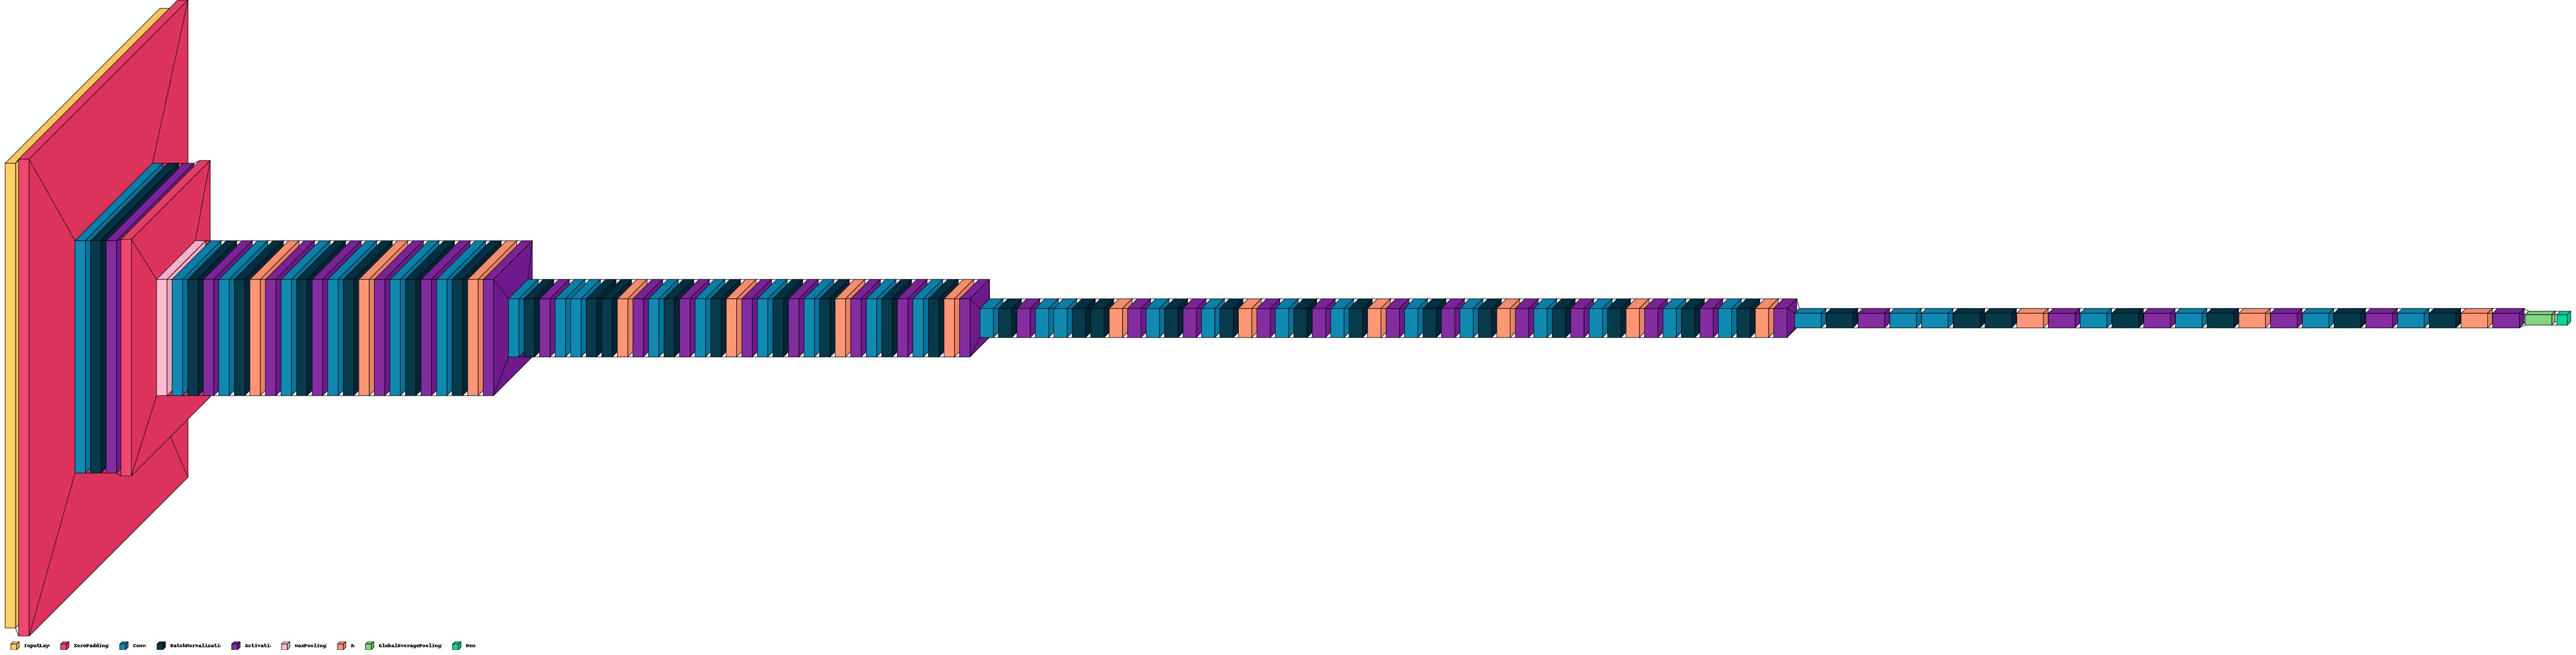

In [ ]:
visualkeras.layered_view(model, legend=True) #visually display the model

In [ ]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

86/86 [==============================] - 56s 20ms/step - loss: 0.2557 - accuracy: 0.9046
Training Loss: 0.2557312846183777
Training Accuracy: 0.9045537114143372
29/29 [==============================] - 3s 105ms/step - loss: 0.3117 - accuracy: 0.9060
Validation Loss: 0.3116895258426666
Validation Accuracy: 0.9060109257698059


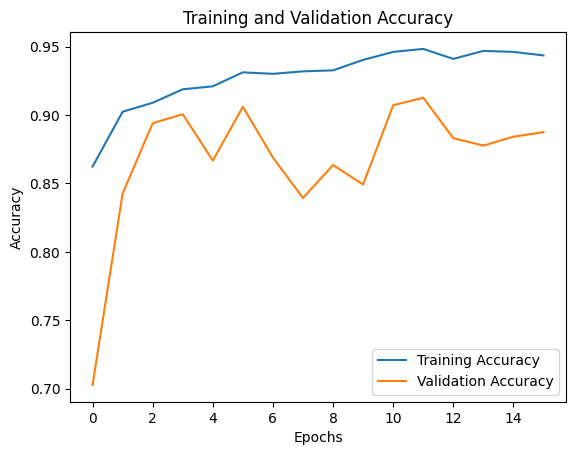

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

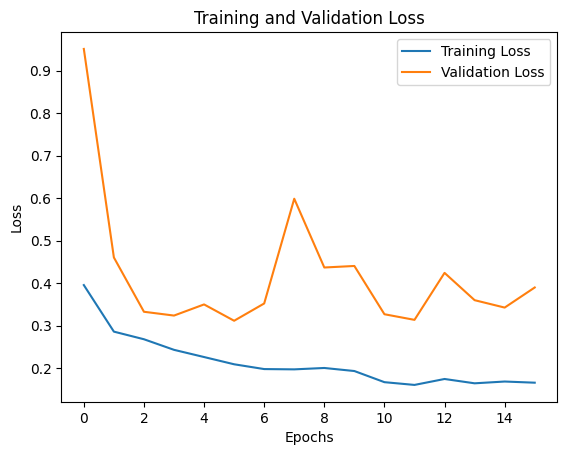

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 29ms/step


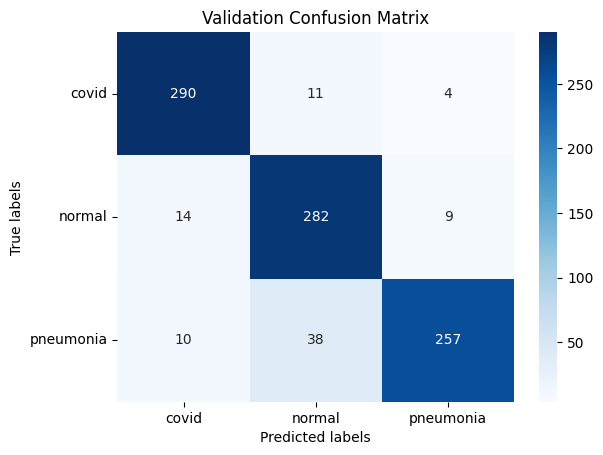

In [ ]:
class_names = ['covid', 'normal', 'pneumonia']
plot_confusion_matrix(val_dataset, model, class_names, title='Validation Confusion Matrix')

# ResNet-50 Architecture

In [ ]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a', kernel_initializer=GlorotUniform(seed=0))(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b', kernel_initializer=GlorotUniform(seed=0))(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c', kernel_initializer=GlorotUniform(seed=0))(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    if input_tensor.shape[-1] != x.shape[-1]:
        shortcut = Conv2D(filters3, (1, 1), strides=(1, 1), name=conv_name_base + '1', kernel_initializer=GlorotUniform(seed=0))(input_tensor)
        shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)
    else:
        shortcut = input_tensor

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def convolutional_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a', kernel_initializer=GlorotUniform(seed=0))(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b', kernel_initializer=GlorotUniform(seed=0))(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c', kernel_initializer=GlorotUniform(seed=0))(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1', kernel_initializer=GlorotUniform(seed=0))(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(input_shape=(224, 224, 1), classes=3):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, 3, [128, 128, 512], stage=3, block='a')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, 3, [256, 256, 1024], stage=4, block='a')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, 3, [512, 512, 2048], stage=5, block='a')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = GlobalAveragePooling2D()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=GlorotUniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    optimizer = Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiating and compiling the ResNet50 model
model = ResNet50(input_shape=(224, 224, 1), classes=3)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 zero_padding2d_8 (ZeroPadd  (None, 230, 230, 1)          0         ['input_10[0][0]']            
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 64)         3200      ['zero_padding2d_8[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1[0][0]']        

**Using resized dataset to train the model:**

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, resize_image, batch_size=32, seed=42)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-50_resized',  # Path and file name to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,               # Log a message for each save
    save_best_only=True,     # Only save a model if `val_accuracy` has improved
    mode='max',              # `max` because we aim to maximize the validation accuracy
    save_weights_only=False  # Save the entire model
)

In [ ]:
# Start timing
start_time = time.time()

# Train the model
epochs = 40
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping_callback, checkpoint_callback]  # Add the callback to the callbacks list
)

# Calculate the total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/40
86/86 [==============================] - ETA: 0s - loss: 1.0161 - accuracy: 0.5468
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-50_resized
86/86 [==============================] - 370s 1s/step - loss: 1.0161 - accuracy: 0.5468 - val_loss: 1.3373 - val_accuracy: 0.3333
Epoch 2/40
86/86 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.6900
Epoch 2: val_accuracy did not improve from 0.33333
86/86 [==============================] - 72s 200ms/step - loss: 0.7418 - accuracy: 0.6900 - val_loss: 2.1219 - val_accuracy: 0.3333
Epoch 3/40
86/86 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.7505
Epoch 3: val_accuracy did not improve from 0.33333
86/86 [==============================] - 71s 198ms/step - loss: 0.6491 - accuracy: 0.7505 - val_loss: 2.4132 - val_accuracy: 0.3333
Epoch 4/40
86/86 [==============================] - ETA: 0s - loss: 0.5624 - acc

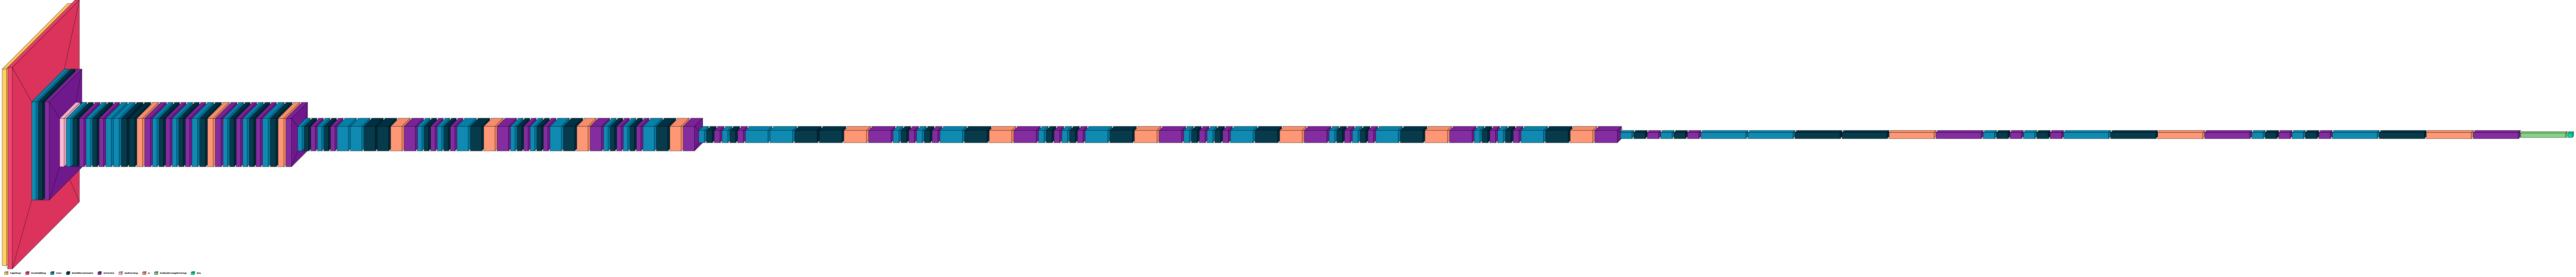

In [ ]:
visualkeras.layered_view(model, legend=True) #visually display the model

In [ ]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

86/86 [==============================] - 59s 59ms/step - loss: 0.3386 - accuracy: 0.8812
Training Loss: 0.3386409878730774
Training Accuracy: 0.8812386393547058
29/29 [==============================] - 3s 104ms/step - loss: 0.3947 - accuracy: 0.8612
Validation Loss: 0.3946709632873535
Validation Accuracy: 0.8612021803855896


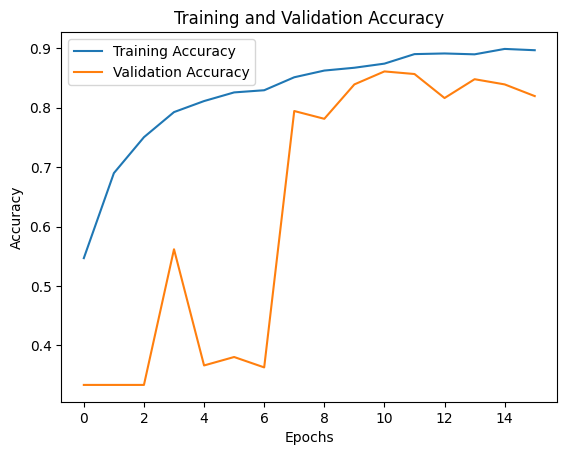

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

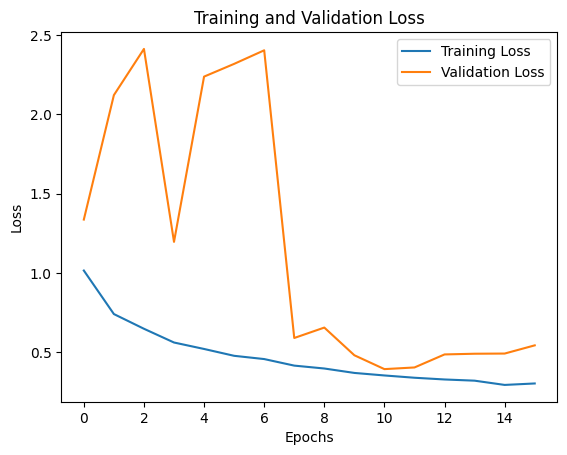

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step


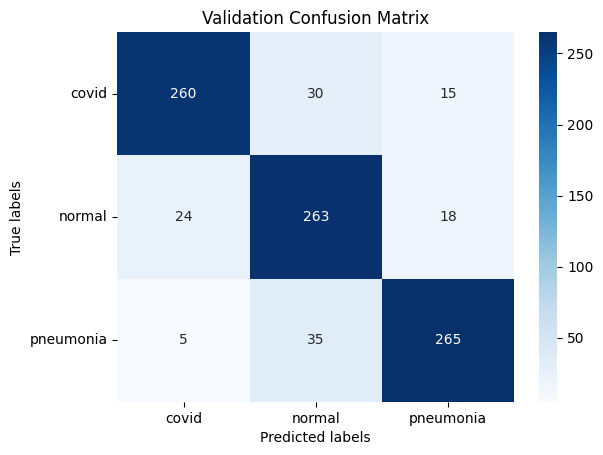

In [ ]:
class_names = ['covid', 'normal', 'pneumonia']
plot_confusion_matrix(val_dataset, model, class_names, title='Validation Confusion Matrix')

**Using padded dataset to train the model:**

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, pad_image, batch_size=32, seed=42)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-50_padded',  # Path and file name to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,               # Log a message for each save
    save_best_only=True,     # Only save a model if `val_accuracy` has improved
    mode='max',              # `max` because we aim to maximize the validation accuracy
    save_weights_only=False  # Save the entire model
)

In [ ]:
# Start timing
start_time = time.time()

# Train the model
epochs = 40
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping_callback, checkpoint_callback]  # Add the callback to the callbacks list
)

# Calculate the total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/40
86/86 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.8237
Epoch 1: val_accuracy improved from -inf to 0.84809, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-50_padded
86/86 [==============================] - 91s 438ms/step - loss: 0.4895 - accuracy: 0.8237 - val_loss: 0.4341 - val_accuracy: 0.8481
Epoch 2/40
86/86 [==============================] - ETA: 0s - loss: 0.3977 - accuracy: 0.8590
Epoch 2: val_accuracy did not improve from 0.84809
86/86 [==============================] - 72s 198ms/step - loss: 0.3977 - accuracy: 0.8590 - val_loss: 0.4895 - val_accuracy: 0.8262
Epoch 3/40
86/86 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8696
Epoch 3: val_accuracy improved from 0.84809 to 0.87432, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-50_padded
86/86 [==============================] - 92s 443ms/step - loss: 0.3578 - accuracy: 0.8696 - val_loss: 0.3903 - val_acc

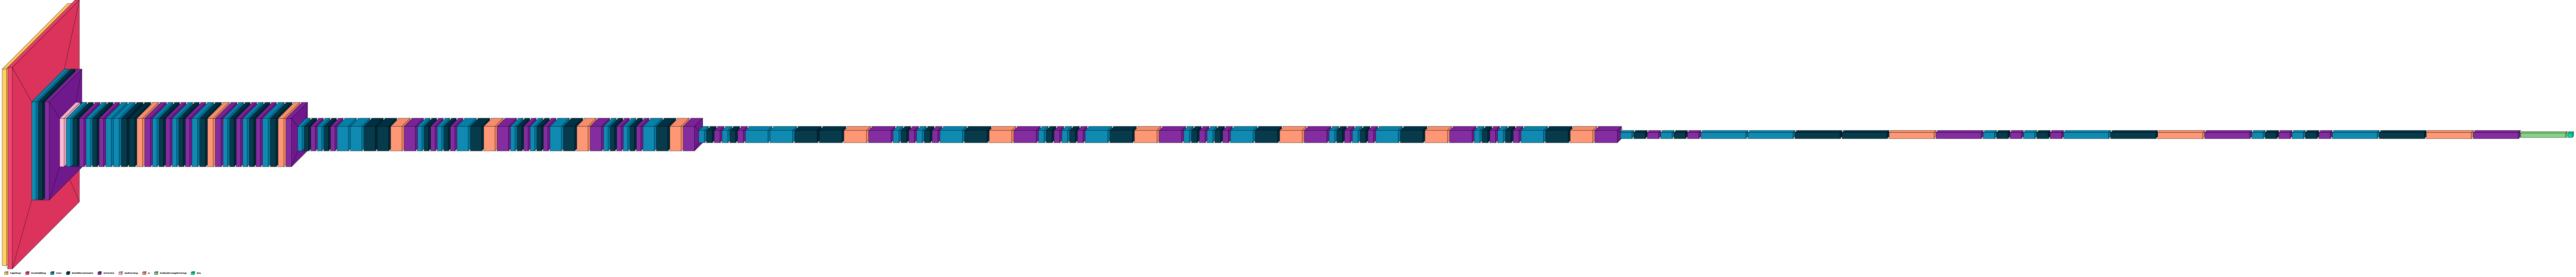

In [ ]:
visualkeras.layered_view(model, legend=True) #visually display the model

In [ ]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

86/86 [==============================] - 58s 48ms/step - loss: 0.2306 - accuracy: 0.9224
Training Loss: 0.23056402802467346
Training Accuracy: 0.9224043488502502
29/29 [==============================] - 3s 104ms/step - loss: 0.3068 - accuracy: 0.8918
Validation Loss: 0.3067915141582489
Validation Accuracy: 0.8918032646179199


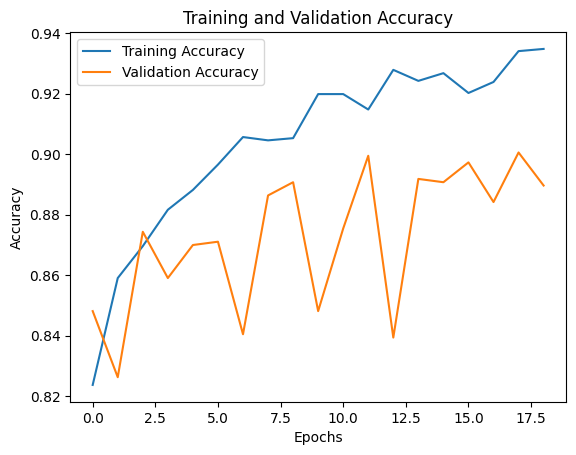

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

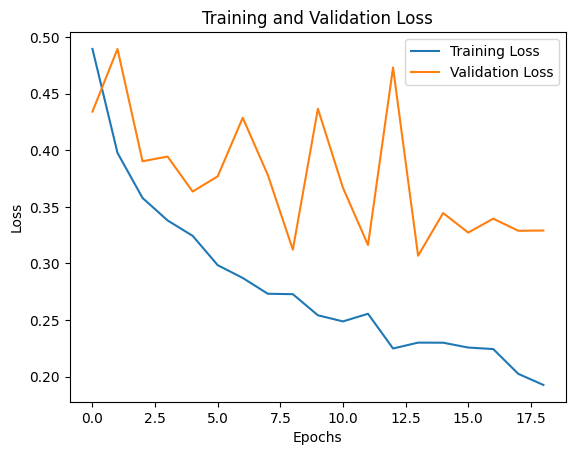

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 32ms/step


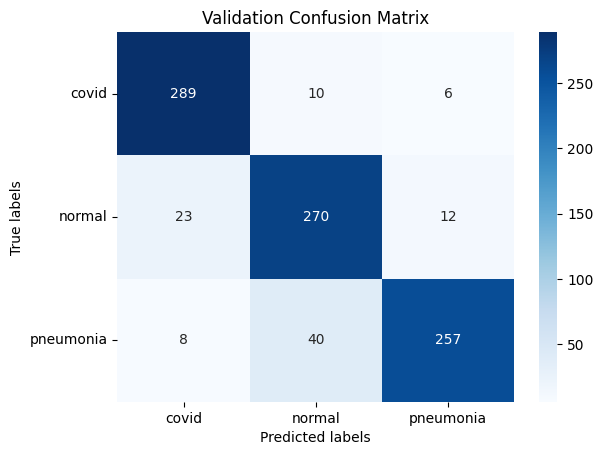

In [ ]:
class_names = ['covid', 'normal', 'pneumonia']
plot_confusion_matrix(val_dataset, model, class_names, title='Validation Confusion Matrix')

# DenseNet-121 Architecture

In [ ]:
def bn_relu_conv(x, filters, kernel_size=3, strides=1):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    return x

def dense_block(x, num_convs, growth_rate):
    for _ in range(num_convs):
        y = bn_relu_conv(x, 4 * growth_rate)
        y = bn_relu_conv(y, growth_rate, kernel_size=1)
        x = Concatenate()([x, y])
    return x

def transition_layer(x, reduction):
    filters = int(tf.keras.backend.int_shape(x)[-1] * reduction)
    x = bn_relu_conv(x, filters, kernel_size=1)
    x = AveragePooling2D(pool_size=2, strides=2)(x)
    return x

def DenseNet121(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D(pool_size=3, strides=2, padding='same')(x)

    # Dense Blocks and Transition Layers
    x = dense_block(x, 6, 32)  # Dense Block 1
    x = transition_layer(x, 0.5)
    x = dense_block(x, 12, 32)  # Dense Block 2
    x = transition_layer(x, 0.5)
    x = dense_block(x, 24, 32)  # Dense Block 3
    x = transition_layer(x, 0.5)
    x = dense_block(x, 16, 32)  # Dense Block 4

    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Instantiate and compile the DenseNet-121 model
model = DenseNet121(input_shape=(224, 224, 1), num_classes=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)  # Set learning rate to 10^-6
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         3136      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0][0

**Using resized dataset to train the model:**

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, resize_image, batch_size=32, seed=42)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/DenseNet-121_resized',  # Path and file name to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,               # Log a message for each save
    save_best_only=True,     # Only save a model if `val_accuracy` has improved
    mode='max',              # `max` because we aim to maximize the validation accuracy
    save_weights_only=False  # Save the entire model
)

In [ ]:
# Start timing
start_time = time.time()

# Increasing the patience value
early_stopping_callback.patience = 10

# Train the model
epochs = 40
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping_callback, checkpoint_callback]  # Add the callback to the callbacks list
)

# Calculate the total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/40
86/86 [==============================] - ETA: 0s - loss: 1.0031 - accuracy: 0.5056
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/DenseNet-121_resized
86/86 [==============================] - 458s 2s/step - loss: 1.0031 - accuracy: 0.5056 - val_loss: 1.1371 - val_accuracy: 0.3333
Epoch 2/40
86/86 [==============================] - ETA: 0s - loss: 0.8793 - accuracy: 0.6324
Epoch 2: val_accuracy did not improve from 0.33333
86/86 [==============================] - 80s 290ms/step - loss: 0.8793 - accuracy: 0.6324 - val_loss: 1.3523 - val_accuracy: 0.3333
Epoch 3/40
86/86 [==============================] - ETA: 0s - loss: 0.8030 - accuracy: 0.6863
Epoch 3: val_accuracy did not improve from 0.33333
86/86 [==============================] - 79s 290ms/step - loss: 0.8030 - accuracy: 0.6863 - val_loss: 1.6730 - val_accuracy: 0.3333
Epoch 4/40
86/86 [==============================] - ETA: 0s - loss: 0.7496 - 

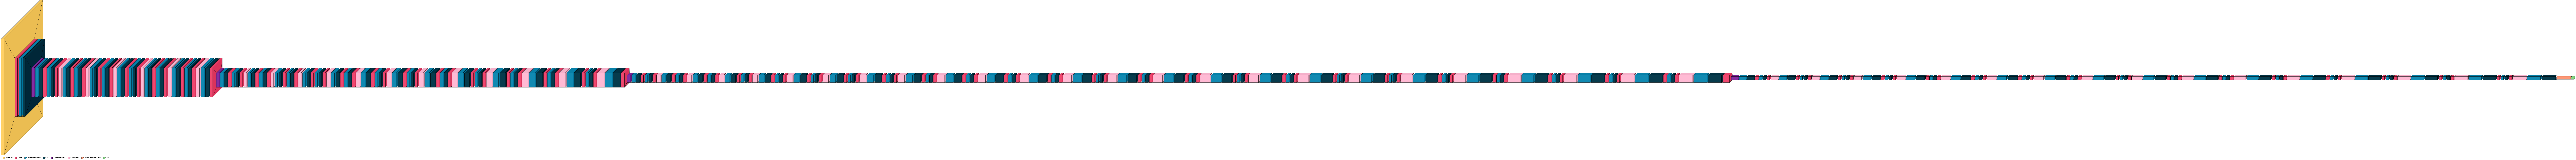

In [ ]:
visualkeras.layered_view(model, legend=True) #visually display the model

In [ ]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

86/86 [==============================] - 66s 146ms/step - loss: 0.2232 - accuracy: 0.9319
Training Loss: 0.22315560281276703
Training Accuracy: 0.9318761229515076
29/29 [==============================] - 4s 112ms/step - loss: 0.2815 - accuracy: 0.9104
Validation Loss: 0.2814946472644806
Validation Accuracy: 0.9103825092315674


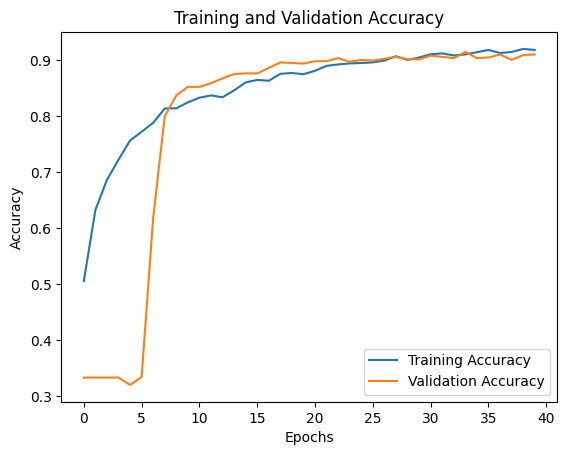

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

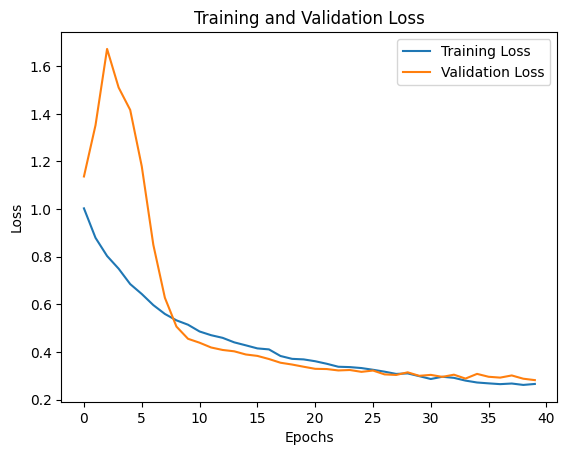

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 5s 5s/step


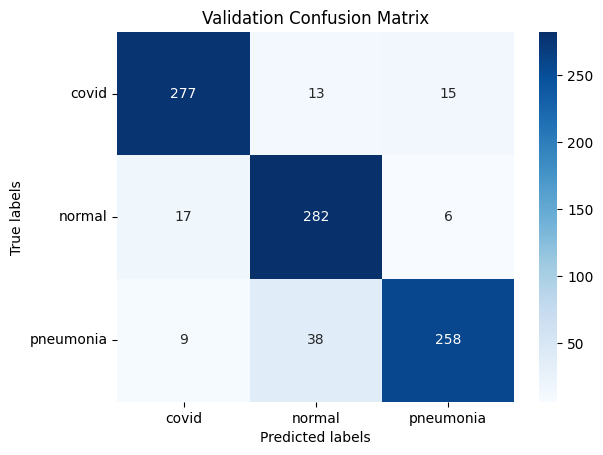

In [ ]:
class_names = ['covid', 'normal', 'pneumonia']
plot_confusion_matrix(val_dataset, model, class_names, title='Validation Confusion Matrix')

**Using padded dataset to train the model:**

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, pad_image, batch_size=32, seed=42)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/DenseNet-121_padded',  # Path and file name to save the model
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,               # Log a message for each save
    save_best_only=True,     # Only save a model if `val_accuracy` has improved
    mode='max',              # `max` because we aim to maximize the validation accuracy
    save_weights_only=False  # Save the entire model
)

In [ ]:
# Start timing
start_time = time.time()

# Increasing the patience
early_stopping_callback.patience = 10

# Train the model
epochs = 40
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping_callback, checkpoint_callback]  # Add the callback to the callbacks list
)

# Calculate the total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/40
86/86 [==============================] - ETA: 0s - loss: 0.8611 - accuracy: 0.6277
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/drive/My Drive/Colab Notebooks/HDA PRO/models/DenseNet-121_padded
86/86 [==============================] - 331s 1s/step - loss: 0.8611 - accuracy: 0.6277 - val_loss: 1.1361 - val_accuracy: 0.3333
Epoch 2/40
86/86 [==============================] - ETA: 0s - loss: 0.7140 - accuracy: 0.7242
Epoch 2: val_accuracy did not improve from 0.33333
86/86 [==============================] - 80s 290ms/step - loss: 0.7140 - accuracy: 0.7242 - val_loss: 1.4042 - val_accuracy: 0.3333
Epoch 3/40
86/86 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.7464
Epoch 3: val_accuracy did not improve from 0.33333
86/86 [==============================] - 79s 291ms/step - loss: 0.6616 - accuracy: 0.7464 - val_loss: 1.9924 - val_accuracy: 0.3333
Epoch 4/40
86/86 [==============================] - ETA: 0s - loss: 0.6147 - a

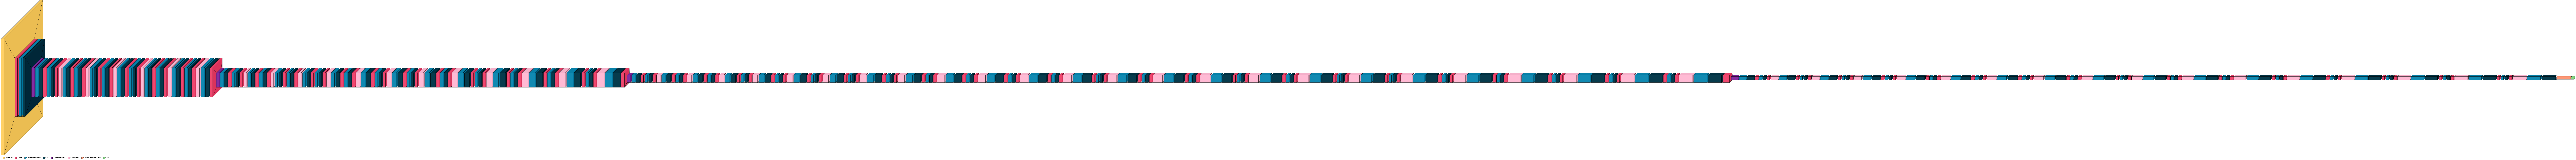

In [ ]:
visualkeras.layered_view(model, legend=True) #visually display the model

In [ ]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

86/86 [==============================] - 67s 146ms/step - loss: 0.1794 - accuracy: 0.9454
Training Loss: 0.17940914630889893
Training Accuracy: 0.9453551769256592
29/29 [==============================] - 4s 111ms/step - loss: 0.2587 - accuracy: 0.9235
Validation Loss: 0.2586623430252075
Validation Accuracy: 0.9234972596168518


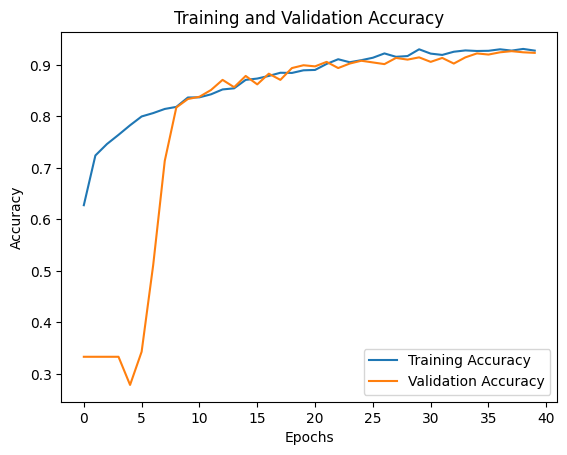

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

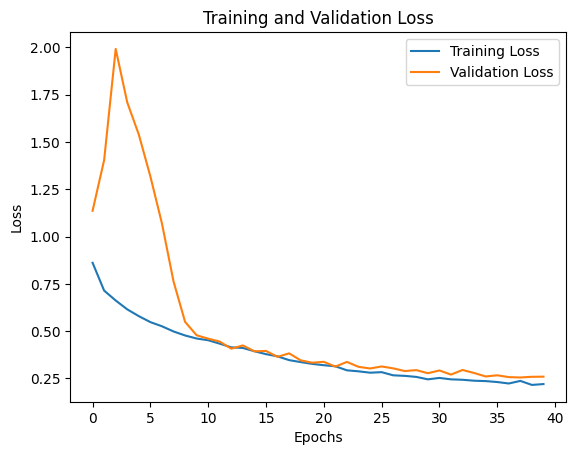

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step


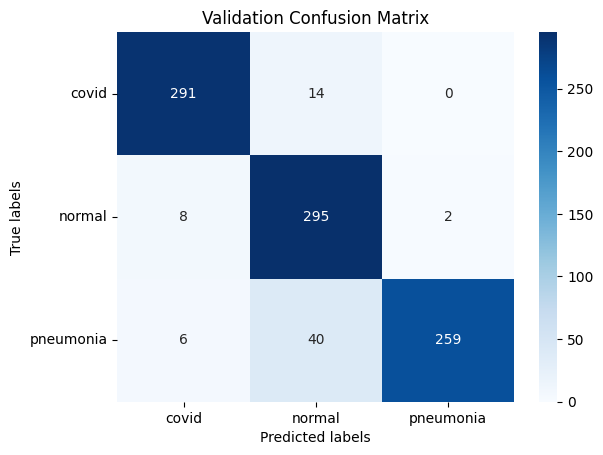

In [ ]:
class_names = ['covid', 'normal', 'pneumonia']
plot_confusion_matrix(val_dataset, model, class_names, title='Validation Confusion Matrix')

# CHOOSING THE BEST MODEL AND EVALUATING THE MODEL ON TEST SET

After analysing the validation dataset for both pre-processing techniques, we have decided that DenseNet-121 padd seemed the best model for our specific task as it has the highest validation accuracy (0.923) and the second-lowest validation loss (0.258). This results of the model indicated that it generalizes well and maintains a good balance between train and validation performance on our specific problem.

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, pad_image, batch_size=32, seed=42)
model = load_model('/content/drive/My Drive/Colab Notebooks/HDA PRO/models/DenseNet-121_padded')

In [ ]:
# Preparing lists to store true labels and predictions
y_true = []
y_pred = []

# Iterating over the test dataset
for images, labels in test_dataset:
    # Make predictions
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Store predictions and true labels
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Calculate and print classification report which includes precision, recall, and F1-score
report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'])
print(report)

1/1 [==============================] - 0s 34ms/step
              precision    recall  f1-score   support

       covid       0.94      0.96      0.95       305
      normal       0.89      0.96      0.92       305
   pneumonia       0.96      0.86      0.91       305

    accuracy                           0.93       915
   macro avg       0.93      0.93      0.93       915
weighted avg       0.93      0.93      0.93       915



# LIVE DEMO OF THE MODELS

In [ ]:
def predict_and_display_image(model_path, test_dataset, class_names, image_index=0):
    """
    Load a model from the given path and predict the class of a single image from the test dataset.

    Parameters:
    - model_path (str): The file path to the trained model.
    - test_dataset (tf.data.Dataset): The dataset containing test images and labels.
    - class_names (list of str): The list of class names corresponding to the model's outputs.
    """
    # Load the previously trained model from the checkpoint
    model = load_model(model_path)

    for test_images, test_labels in test_dataset.take(1):  # Take 1 batch from the dataset
        # Selecting the first image and label from the batch
        single_test_image, single_test_label = test_images[image_index], test_labels[image_index]
        single_test_image_expanded = tf.expand_dims(single_test_image, 0)  # Adding batch dimension for prediction

        # Predict the label of the test image using our loaded model
        predictions = model.predict(single_test_image_expanded)
        predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of the max log-probability

        # Output the results
        print("Predictions:", predictions)  # Show raw probabilities
        print("Predicted Class Index:", predicted_class)
        print("Predicted Class Name:", class_names[predicted_class])
        print("Actual Label Index:", single_test_label.numpy())
        print("Actual Class Name:", class_names[single_test_label.numpy()])

        # Plotting the image
        plt.figure(figsize=(2, 2))
        plt.imshow(single_test_image.numpy().squeeze(), cmap='gray')
        plt.title(f"Predicted: {class_names[predicted_class]}, Actual: {class_names[single_test_label.numpy()]}")
        plt.axis('off')
        plt.show()


 # Live Demo Examples for each model for resized image dataset:

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, resize_image, batch_size=32, seed=42)
class_names = ['covid', 'normal', 'pneumonia']

Custom_CNN_resized for resized image dataset

1/1 [==============================] - 0s 85ms/step
Predictions: [[0.5799474  0.36439463 0.0556579 ]]
Predicted Class Index: 0
Predicted Class Name: covid
Actual Label Index: 0
Actual Class Name: covid


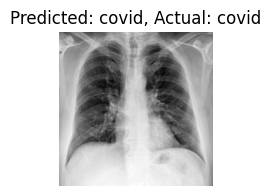

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/Custom_CNN_resized'
predict_and_display_image(model_path, test_dataset, class_names)

Second_Custom_CNN_resized for resized image dataset

1/1 [==============================] - 0s 113ms/step
Predictions: [[0.7294693  0.23056613 0.03996461]]
Predicted Class Index: 0
Predicted Class Name: covid
Actual Label Index: 0
Actual Class Name: covid


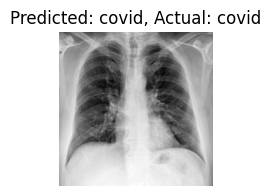

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/Second_Custom_CNN_resized'
predict_and_display_image(model_path, test_dataset, class_names)

ResNet-34_resized for resized image dataset

1/1 [==============================] - 1s 998ms/step
Predictions: [[0.27898636 0.71907115 0.00194247]]
Predicted Class Index: 1
Predicted Class Name: normal
Actual Label Index: 0
Actual Class Name: covid


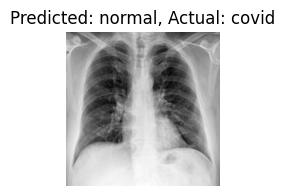

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-34_resized'
predict_and_display_image(model_path, test_dataset, class_names)

ResNet-50_resized for resized image dataset

1/1 [==============================] - 1s 941ms/step
Predictions: [[0.58231235 0.41458723 0.00310047]]
Predicted Class Index: 0
Predicted Class Name: covid
Actual Label Index: 0
Actual Class Name: covid


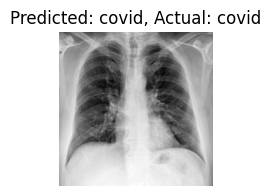

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-50_resized'
predict_and_display_image(model_path, test_dataset, class_names)

DenseNet-121_resized for resized image dataset

1/1 [==============================] - 2s 2s/step
Predictions: [[0.71478975 0.27247512 0.01273507]]
Predicted Class Index: 0
Predicted Class Name: covid
Actual Label Index: 0
Actual Class Name: covid


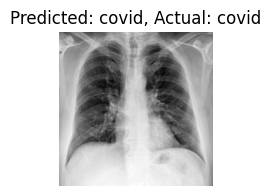

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/DenseNet-121_resized'
predict_and_display_image(model_path, test_dataset, class_names)

# Live Demo Examples for each model for padded image dataset:

In [ ]:
train_dataset, val_dataset, test_dataset = create_train_val_test_datasets(df, pad_image, batch_size=32, seed=42)
class_names = ['covid', 'normal', 'pneumonia']

Custom_CNN for padded image dataset

1/1 [==============================] - 0s 94ms/step
Predictions: [[0.71709543 0.26678336 0.01612121]]
Predicted Class Index: 0
Predicted Class Name: covid
Actual Label Index: 0
Actual Class Name: covid


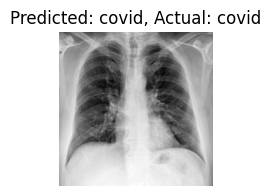

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/Custom_CNN_padded'
predict_and_display_image(model_path, test_dataset, class_names)

Second_Custom_CNN_padded for padded image dataset

1/1 [==============================] - 0s 132ms/step
Predictions: [[0.802508   0.17393743 0.02355456]]
Predicted Class Index: 0
Predicted Class Name: covid
Actual Label Index: 0
Actual Class Name: covid


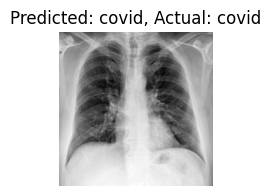

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/Second_Custom_CNN_padded'
predict_and_display_image(model_path, test_dataset, class_names)

ResNet-34_padded for padded image dataset

1/1 [==============================] - 1s 677ms/step
Predictions: [[9.9170262e-01 7.6951329e-03 6.0219446e-04]]
Predicted Class Index: 0
Predicted Class Name: covid
Actual Label Index: 0
Actual Class Name: covid


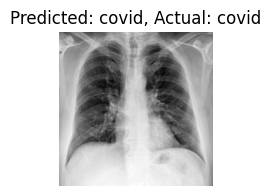

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-34_padded'
predict_and_display_image(model_path, test_dataset, class_names)

ResNet-50_padded for padded image dataset

1/1 [==============================] - 1s 947ms/step
Predictions: [[0.8295407  0.16669163 0.00376771]]
Predicted Class Index: 0
Predicted Class Name: covid
Actual Label Index: 0
Actual Class Name: covid


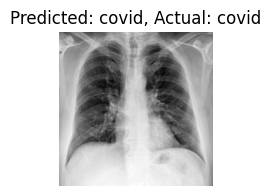

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/ResNet-50_padded'
predict_and_display_image(model_path, test_dataset, class_names)

DenseNet-121_padded for padded image dataset

1/1 [==============================] - 2s 2s/step
Predictions: [[9.9999392e-01 4.6026607e-06 1.4749057e-06]]
Predicted Class Index: 0
Predicted Class Name: covid
Actual Label Index: 0
Actual Class Name: covid


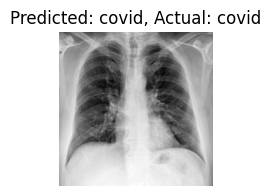

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/HDA PRO/models/DenseNet-121_padded'
predict_and_display_image(model_path, test_dataset, class_names)